#Hand motion recognition

The goal of this model is to build a tensorflow model that can recognize 4 different hand motions. Swiping up, left, down and right. For that an Arduino Nano 33 BLE Sense is attached to the pinky finger of the right hand. The Arduino should be facing the palm and the port for connecting the USB cable faces towards the root of the finger.

## Install and import libraries

In [75]:
%pip install tensorflow pandas numpy plotly
!apt install -y xxd

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Reading package lists... Done
Building dependency tree       
Reading state information... Done
xxd is already the newest version (2:8.1.2269-1ubuntu5.15).
0 upgraded, 0 newly installed, 0 to remove and 46 not upgraded.


In [76]:
from google.colab import drive
import numpy as np
import tensorflow as tf
from tensorflow import keras
import pandas as pd
import matplotlib.pyplot as plt
from keras.utils import plot_model

In [77]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


#*Place csv data provided in the repository (in data folder) in own Google Drive folder and modify the path below to the folder they are located in.*

In [78]:
data_path = "/content/drive/MyDrive/IoT_Project/data/"

## Parse and prepare data

Data for 4 swiping motions up, left, down and right has been recorded. There is additional recorded data for clockwise and counterclockwise hand motions, however they have been excluded as the current accuracy on the Arduino Nano 33 BLE Sense is too low.

From:
https://docs.arduino.cc/tutorials/nano-33-ble-sense/imu-accelerometer (last access 28 May 2023)

Accelerometer range is set at [-4, +4]g -/+0.122 mg.

Gyroscope range is set at [-2000, +2000] dps +/-70 mdps.

In [79]:
GESTURES = ["up", "left", "down", "right"] # , "counterclockwise", "clockwise"]
SAMPLES_PER_GESTURE = 128
SAMPLES_TAKEN_INTO_ACCOUNT = 128
NUM_GESTURES = len(GESTURES)

# The form of the input is a 3D array.
# 1st dimension: Recordings of full gestures. Size: num_recordings * NUM_GESTURES
# 2nd dimension: All samples for one gesture. Size: SAMPLES_TAKEN_INTO_ACCOUNT
# 3rd dimension: All measuremnts per sample taken. E.g. [accX, accY, accZ, gyrX, gyrY, gyrZ]
inputs = []
# Outputs is an array of length num_recordings * NUM_GESTURES
# The values are in range [0, NUM_GESTURES]
outputs = []

for gesture_idx in range(NUM_GESTURES):
  gesture = GESTURES[gesture_idx]
  output = gesture_idx

  # Save data for a gesture into a dataframe
  df = pd.read_csv(data_path + gesture + ".csv")

  _num_recordings = int(df.shape[0] / SAMPLES_PER_GESTURE)
  num_recordings = 180 # Number of recordings actually taken into account

  print(f"\tCollected {_num_recordings} recordings of the {gesture} gesture. Using {num_recordings}")

  # Create the inputs for the model from the dataframe
  for rec_idx in range(num_recordings):
    recording = [] # Array for storing all recorded gestures.
    # Per recording an array of all samples is added.
    # resulting recording array is e.g. [[accX1, accY1, accZ1, ...], [accX2, accY2, ...]]
    for sample_idx in range(SAMPLES_TAKEN_INTO_ACCOUNT):
      idx = rec_idx * SAMPLES_PER_GESTURE + sample_idx
      # Append recordings that have been scaled to a scale [0,1]
      recording.append([
          (df['accX'][idx] + 4) / 8,
          (df['accY'][idx] + 4) / 8,
          (df['accZ'][idx] + 4) / 8,
          (df['gyrX'][idx] + 2000) / 4000,
          (df['gyrY'][idx] + 2000) / 4000,
          (df['gyrZ'][idx] + 2000) / 4000,
      ])

    inputs.append(recording)
    outputs.append(output)

inputs = np.array(inputs)
input_shape = np.shape(inputs)
outputs = np.array(outputs)
output_shape = np.shape(outputs)
print(f"Input shape is {input_shape}. Output shape is {output_shape}")

	Collected 182 recordings of the up gesture. Using 180
	Collected 224 recordings of the left gesture. Using 180
	Collected 201 recordings of the down gesture. Using 180
	Collected 252 recordings of the right gesture. Using 180
Input shape is (720, 128, 6). Output shape is (720,)


## Visualize recorded data

In [80]:
def windowed_mean(arr, window_size, step_size):
  """
  Takes an array and returns the mean windowed version of it
  Parameters:
    arr: Array of integers or floats that is supposed to be windowed
    window_size: Size of the window of which mean should be computed
    step_size: amount of indices the window is moved to compute different means over the whole length of the array
  Returns:
    WIndowed array of integers or floats

  Example:
    windowed_mean([1,3,5,7], 2, 1) -> [2,4,6]
  """
  result = []
  for i in range(0, len(arr) - window_size + 1, step_size):
      window = arr[i:i+window_size]
      mean_value = np.mean(window)
      result.append(mean_value)
  return result

## Visualize input data
We want to visualize input data to understand it and can see which features might be useful to extract.

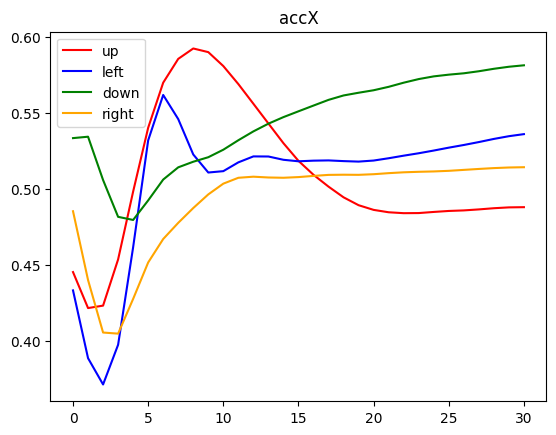

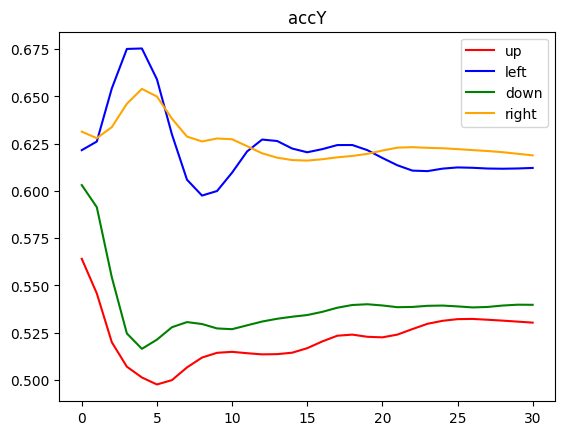

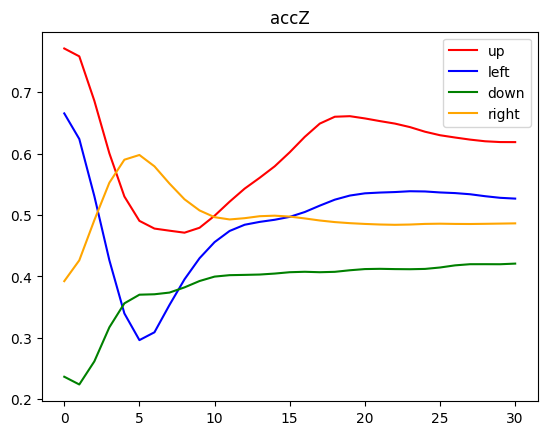

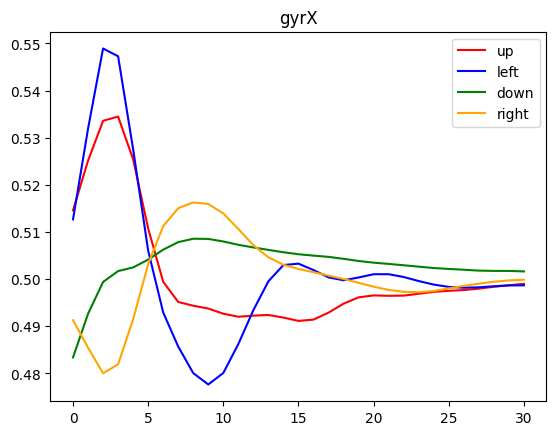

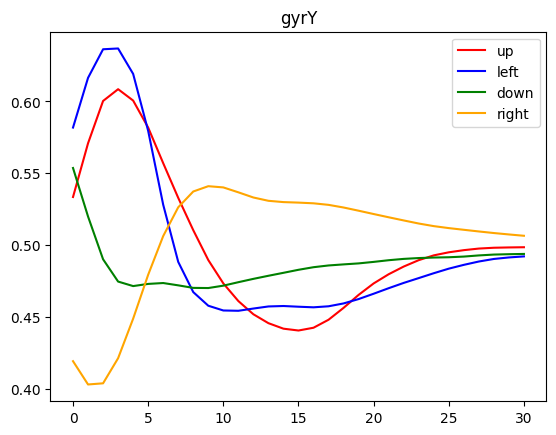

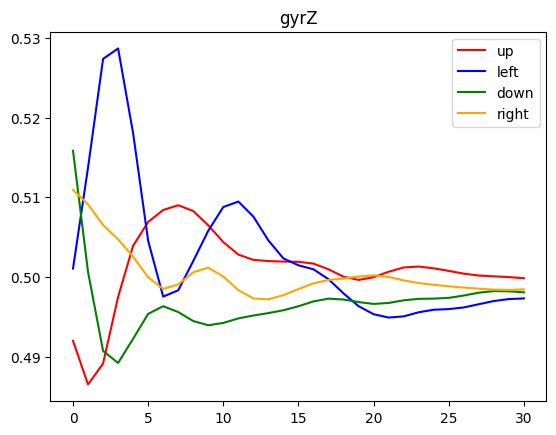

In [81]:
inputs_transposed = []
# Transpose all the recordings to have the values of the same kind (e.g. accX) in one array.
for i, input in enumerate(inputs):
  transposed_matrix = [list(row) for row in zip(*input)]
  inputs_transposed.append(transposed_matrix)


# Window the inputs to make the graph smoother
num_input_params = np.shape(inputs_transposed)[1]
for sample in inputs_transposed:
  for idx in range(num_input_params):
    sample[idx] = windowed_mean(sample[idx], 8, 4)

# For every sampled values (e.g. accX) construct a graph
for idx, measure in enumerate(df.columns.tolist()):
  recordings = []
  # Accumulate all recordings of this value per gesture
  for gesture_idx in range(NUM_GESTURES):
    gesture_recordings = inputs_transposed[gesture_idx * num_recordings: (gesture_idx + 1) * num_recordings]
    recordings_for_parameter = [subarray[idx] for subarray in gesture_recordings]
    recordings.append(recordings_for_parameter)

  colors = ['red', 'blue', 'green', 'orange', 'purple', 'brown']
  labels = GESTURES

  # Create graphs for all recorded values
  for gesture_idx in range(NUM_GESTURES):
    gestures = recordings[gesture_idx]
    gesture_mean = [sum(column) / len(column) for column in zip(*gestures)]
    plt.plot(gesture_mean, color=colors[gesture_idx], label=labels[gesture_idx])

  plt.title(measure)
  plt.legend()
  plt.show()

## Train Model

First we split the data into training:test:validation 6:2:2

In [82]:
num_inputs = len(inputs)
randomize = np.arange(num_inputs)
np.random.shuffle(randomize)

inputs = inputs[randomize]
outputs = outputs[randomize]

TRAIN_SPLIT = int(0.6 * num_inputs)
TEST_SPLIT = int(0.2 * num_inputs + TRAIN_SPLIT)

X_train, X_test, X_val = np.split(inputs, [TRAIN_SPLIT, TEST_SPLIT])
y_train, y_test, y_val = np.split(outputs, [TRAIN_SPLIT, TEST_SPLIT])

Then we build a model...

In [83]:
model = keras.models.Sequential([
    keras.layers.Flatten(),#input_shape = (np.shape(inputs)[1], np.shape(inputs)[2])),
    keras.layers.Dense(
        units = 32,
        activation=keras.activations.relu,
        kernel_initializer=keras.initializers.HeNormal(seed=42),
    ),
    keras.layers.Dense(
        units = 16,
        activation=keras.activations.relu,
        kernel_initializer=keras.initializers.HeNormal(seed=42),
    ),
    keras.layers.Dense(NUM_GESTURES, activation='softmax')
])

"""
keras.models.Sequential([
    keras.layers.BatchNormalization(input_shape = (np.shape(inputs)[1], np.shape(inputs)[2])),
    keras.layers.Conv1D(
        filters=1, kernel_size=8, strides = 4,
        activation = keras.activations.relu,
        kernel_initializer=keras.initializers.HeNormal(seed=42),
    ),
    keras.layers.BatchNormalization(),
    keras.layers.Flatten(),
    keras.layers.Dense(
        units = 16,
        activation=keras.activations.relu,
        kernel_initializer=keras.initializers.HeNormal(seed=42),
    ),
    keras.layers.Dense(NUM_GESTURES, activation='softmax')
])
"""
#print(model.summary())

"\nkeras.models.Sequential([\n    keras.layers.BatchNormalization(input_shape = (np.shape(inputs)[1], np.shape(inputs)[2])),\n    keras.layers.Conv1D(\n        filters=1, kernel_size=8, strides = 4, \n        activation = keras.activations.relu, \n        kernel_initializer=keras.initializers.HeNormal(seed=42),\n    ), \n    keras.layers.BatchNormalization(),\n    keras.layers.Flatten(), \n    keras.layers.Dense(\n        units = 16, \n        activation=keras.activations.relu,\n        kernel_initializer=keras.initializers.HeNormal(seed=42),\n    ),\n    keras.layers.Dense(NUM_GESTURES, activation='softmax')\n])\n"

Compile and train model

In [84]:
model.compile(
    loss=keras.losses.SparseCategoricalCrossentropy(),
    optimizer=keras.optimizers.Adam(),
    metrics=[
            keras.metrics.SparseCategoricalAccuracy(),
    ]
)

history = model.fit(
    x=X_train,
    y=y_train,
    batch_size=10,
    epochs= 40 ,
    validation_data=(X_val, y_val)
)

Epoch 1/40
44/44 [==============================] - 6s 39ms/step - loss: 1.4436 - sparse_categorical_accuracy: 0.2731 - val_loss: 1.3244 - val_sparse_categorical_accuracy: 0.4792
Epoch 2/40
44/44 [==============================] - 1s 18ms/step - loss: 1.2423 - sparse_categorical_accuracy: 0.6458 - val_loss: 1.2157 - val_sparse_categorical_accuracy: 0.4583
Epoch 3/40
44/44 [==============================] - 1s 23ms/step - loss: 1.1052 - sparse_categorical_accuracy: 0.6806 - val_loss: 0.9987 - val_sparse_categorical_accuracy: 0.7292
Epoch 4/40
44/44 [==============================] - 1s 20ms/step - loss: 0.9379 - sparse_categorical_accuracy: 0.6389 - val_loss: 0.7958 - val_sparse_categorical_accuracy: 0.9306
Epoch 5/40
44/44 [==============================] - 0s 11ms/step - loss: 0.7034 - sparse_categorical_accuracy: 0.8981 - val_loss: 0.6366 - val_sparse_categorical_accuracy: 0.8750
Epoch 6/40
44/44 [==============================] - 0s 9ms/step - loss: 0.5481 - sparse_categorical_accur

## Model evaluation

In [85]:
from sklearn.metrics import confusion_matrix
import plotly.express as px

# Politely stolen from one of the classes training notebooks :)
def plot_confusion_matrix(y_true, y_pred, classes, normalize=False):

  tv = list(map(lambda x: GESTURES[x], classes))

  cm = confusion_matrix(y_true, y_pred)
  if normalize:
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

  fig = px.imshow(cm, text_auto=True, aspect='auto', color_continuous_scale='blues')
  fig.update_layout(height=400, width=400, title='Confusion matrix of the classifier', coloraxis_showscale=False)
  fig.update_xaxes(title='Predicted', tickvals=classes, ticktext=classes, tickmode='array')
  fig.update_yaxes(title='True', tickvals=classes, ticktext=classes, tickmode='array')
  fig.show()

In [86]:
from sklearn.metrics import confusion_matrix
y_pred = model.predict(X_test)
classes = np.arange(NUM_GESTURES)

y_pred = list(map(lambda x: np.argmax(x), y_pred))

plot_confusion_matrix(y_test, y_pred, classes=classes)

loss, accuracy = model.evaluate(X_test, y_test)

print(f"Loss: {loss}, Accuracy: {accuracy}")

5/5 [==============================] - 0s 4ms/step


5/5 [==============================] - 0s 9ms/step - loss: 0.0300 - sparse_categorical_accuracy: 0.9931
Loss: 0.030011944472789764, Accuracy: 0.9930555820465088


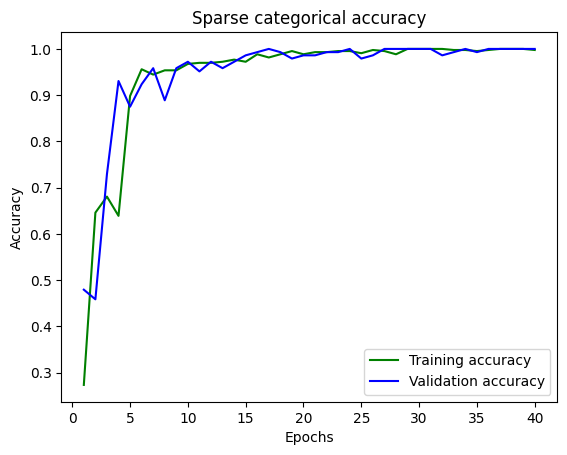

In [93]:
loss = history.history['sparse_categorical_accuracy']
val_loss = history.history['val_sparse_categorical_accuracy']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'g', label='Training accuracy')
plt.plot(epochs, val_loss, 'b', label='Validation accuracy')
plt.title('Sparse categorical accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

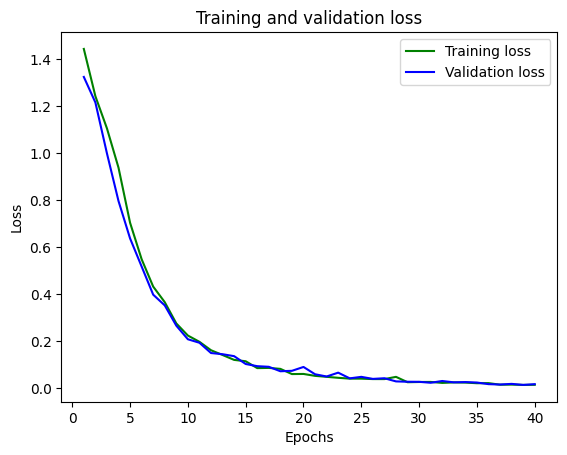

In [88]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'g', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

## Model conversion

In [89]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()
model_tflite_path = data_path + "model.tflite"
model_tflite_micro_path = data_path + "model.cc"
open(model_tflite_path, "wb").write(tflite_model)

import os
basic_model_size = os.path.getsize(model_tflite_path)
print("Model is %d bytes" % basic_model_size)

Model is 103280 bytes


In [90]:
# Install xxd if it is not available
!apt-get update && apt-get -qq install xxd
# Convert to a C source file
!xxd -i {model_tflite_path} > {model_tflite_micro_path}
# Update variable names
REPLACE_TEXT = model_tflite_path.replace('/', '_').replace('.', '_')
!sed -i 's/'{REPLACE_TEXT}'/g_model/g' {model_tflite_micro_path}

Hit:1 https://cloud.r-project.org/bin/linux/ubuntu focal-cran40/ InRelease
Hit:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2004/x86_64  InRelease
Hit:3 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu focal InRelease
Hit:4 http://archive.ubuntu.com/ubuntu focal InRelease
Hit:5 http://security.ubuntu.com/ubuntu focal-security InRelease
Hit:6 http://ppa.launchpad.net/cran/libgit2/ubuntu focal InRelease
Hit:7 http://archive.ubuntu.com/ubuntu focal-updates InRelease
Hit:8 http://archive.ubuntu.com/ubuntu focal-backports InRelease
Hit:9 http://ppa.launchpad.net/deadsnakes/ppa/ubuntu focal InRelease
Hit:10 http://ppa.launchpad.net/graphics-drivers/ppa/ubuntu focal InRelease
Hit:11 http://ppa.launchpad.net/ubuntugis/ppa/ubuntu focal InRelease
Reading package lists... Done


In [91]:
!cat {model_tflite_micro_path}

unsigned char g_model[] = {
  0x1c, 0x00, 0x00, 0x00, 0x54, 0x46, 0x4c, 0x33, 0x14, 0x00, 0x20, 0x00,
  0x1c, 0x00, 0x18, 0x00, 0x14, 0x00, 0x10, 0x00, 0x0c, 0x00, 0x00, 0x00,
  0x08, 0x00, 0x04, 0x00, 0x14, 0x00, 0x00, 0x00, 0x1c, 0x00, 0x00, 0x00,
  0x98, 0x00, 0x00, 0x00, 0xf0, 0x00, 0x00, 0x00, 0xf4, 0x8b, 0x01, 0x00,
  0x04, 0x8c, 0x01, 0x00, 0xfc, 0x92, 0x01, 0x00, 0x03, 0x00, 0x00, 0x00,
  0x01, 0x00, 0x00, 0x00, 0x10, 0x00, 0x00, 0x00, 0x00, 0x00, 0x0a, 0x00,
  0x10, 0x00, 0x0c, 0x00, 0x08, 0x00, 0x04, 0x00, 0x0a, 0x00, 0x00, 0x00,
  0x0c, 0x00, 0x00, 0x00, 0x1c, 0x00, 0x00, 0x00, 0x3c, 0x00, 0x00, 0x00,
  0x0f, 0x00, 0x00, 0x00, 0x73, 0x65, 0x72, 0x76, 0x69, 0x6e, 0x67, 0x5f,
  0x64, 0x65, 0x66, 0x61, 0x75, 0x6c, 0x74, 0x00, 0x01, 0x00, 0x00, 0x00,
  0x04, 0x00, 0x00, 0x00, 0x90, 0xff, 0xff, 0xff, 0x0c, 0x00, 0x00, 0x00,
  0x04, 0x00, 0x00, 0x00, 0x08, 0x00, 0x00, 0x00, 0x64, 0x65, 0x6e, 0x73,
  0x65, 0x5f, 0x32, 0x36, 0x00, 0x00, 0x00, 0x00, 0x01, 0x00, 0x00, 0x00,
  0x04, 0x

In [92]:

!echo "const unsigned char model[] = {" > /content/model.h
!cat gesture_model.tflite | xxd -i      >> /content/model.h
!echo "};"                              >> /content/model.h

import os
model_h_size = os.path.getsize("model.h")
print(f"Header file, model.h, is {model_h_size:,} bytes.")
print("\nOpen the side panel (refresh if needed). Double click model.h to download the file.")

cat: gesture_model.tflite: No such file or directory
Header file, model.h, is 35 bytes.

Open the side panel (refresh if needed). Double click model.h to download the file.
